<a href="https://colab.research.google.com/github/kimalpaca/Advanced-Graphics-Programming/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install xvfb
!apt-get install python3-tk
!pip install numpy==1.23.5
!pip install tk
!pip install gym[box2d]
!pip install gym-notebook-wrapper
!export MPLBACKEND=TKAg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [75.2 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,604 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,842 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Hit:13 http://archive.ubun

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/build_env.py", line 19, in <module>
^C
^C


In [ ]:
import gym
import torch
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
import imageio

In [ ]:
env = gym.envs.make("Acrobot-v1")

In [ ]:
def plot_res(values, title='DQN'):
    clear_output(wait=True)
    scores = [500 + v for v in values]
    x = range(len(scores))
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title)

    ax[0].plot(x, scores, label='score per run')
    ax[0].axhline(400, c='red', ls='--', label='success zone')
    try:
        z = np.polyfit(x, scores, 1)
        p = np.poly1d(z)
        ax[0].plot(x, p(x), '--', color='orange')
    except:
        pass
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Score (higher is better)')
    ax[0].legend()

    ax[1].hist(scores[-500:])
    ax[1].axvline(400, c='red', label='success zone')
    ax[1].set_xlabel('Scores per Last 500 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()

    plt.show()

In [ ]:
class DQN():
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.001):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim * 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim * 2, action_dim)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.criterion = torch.nn.MSELoss()

    def predict(self, state):
        with torch.no_grad():
            return self.model(torch.tensor([state], dtype=torch.float32))

    def update(self, state, y):
        y_pred = self.model(torch.tensor([state], dtype=torch.float32))
        y_true = torch.tensor([y], dtype=torch.float32)
        loss = self.criterion(y_pred, y_true)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
def q_learning(env, model, episodes, gamma=0.9,
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=64,
               title='DQL', double=False,
               n_update=10, soft=False, verbose=True):
    final = []
    memory = []
    episode_i = 0
    sum_total_replay_time = 0
    best_score = -1

    for episode in range(episodes):
        episode_i += 1
        if double and not soft:
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()

        state = env.reset()
        done = False
        total = 0
        step = 0

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            total += reward
            memory.append((state, action, next_state, reward, done))

            if done:
                if not replay:
                    q_values = model.predict(state).tolist()[0]
                    q_values[action] = reward
                    model.update(state, q_values)
                break

            if replay and step % 5 == 0:  # ✅ 5스텝마다 replay로 속도 개선
                t0 = time.time()
                model.replay(memory, replay_size, gamma)
                t1 = time.time()
                sum_total_replay_time += (t1 - t0)
            elif not replay:
                q_values = model.predict(state).tolist()[0]
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
            step += 1

        epsilon = max(epsilon * eps_decay, 0.05)
        final.append(total)

        score = 500 + total  # ✅ 양수 점수화
        if score > best_score:
            best_score = score

        plot_res(final, title)

        if verbose:
            print(f"ep: {episode_i:4d}  score: {score:.2f}  best: {best_score:.2f}")
            if replay:
                print(f"Average replay time: {sum_total_replay_time / episode_i:.4f} sec")

    return final


In [ ]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 250
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

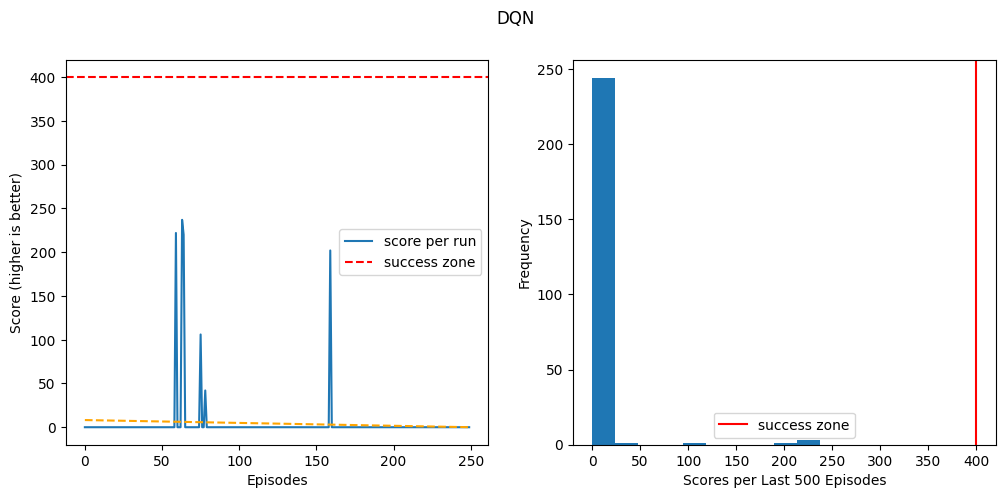

ep:  250  score: 0.00  best: 237.00


In [ ]:
# Get replay results
dqn = DQN(n_state, n_action, n_hidden, lr)
result = q_learning(env, dqn, episodes, gamma=0.90, epsilon=0.3, title='DQN')


In [ ]:
env_ani = gnwrapper.Monitor(gym.make("Acrobot-v1", render_mode="single_rgb_array"))
observation = env_ani.reset(seed=1000)

for t in range(500):
    qs = dqn_double.predict(observation)
    action = torch.argmax(qs).item()
    observation, reward, done, _ = env_ani.step(action)
    if done:
        print(f"종료 at step {t}")
        break

env_ani.display()


NameError: name 'gnwrapper' is not defined